# Imports

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import torchvision.models as models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from ultralytics import YOLO
from pathlib import Path
import random
import cv2
import numpy as np
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!unzip drive/MyDrive/dataset.zip

Archive:  drive/MyDrive/dataset.zip
   creating: dataset/
   creating: dataset/images/
   creating: dataset/images/fake/
  inflating: dataset/images/fake/100.jpg  
  inflating: dataset/images/fake/1000.jpg  
  inflating: dataset/images/fake/1001.jpg  
  inflating: dataset/images/fake/1002.jpg  
  inflating: dataset/images/fake/1003.jpg  
  inflating: dataset/images/fake/1004.jpg  
  inflating: dataset/images/fake/1005.jpg  
  inflating: dataset/images/fake/1006.jpg  
  inflating: dataset/images/fake/1007.jpg  
  inflating: dataset/images/fake/1008.jpg  
  inflating: dataset/images/fake/1009.jpg  
  inflating: dataset/images/fake/101.jpg  
  inflating: dataset/images/fake/1010.jpg  
  inflating: dataset/images/fake/1011.jpg  
  inflating: dataset/images/fake/1012.jpg  
  inflating: dataset/images/fake/1013.jpg  
  inflating: dataset/images/fake/1014.jpg  
  inflating: dataset/images/fake/1015.jpg  
  inflating: dataset/images/fake/1016.jpg  
  inflating: dataset/images/fake/1017.jpg  
 

In [5]:
current_device = 'cuda' if torch.cuda.is_available() else 'cpu'
face_detector = YOLO('yolov8n-face.pt')

# Pre processing

In [6]:
def preprocess_videos(video_dir, output_dir, num_frames=20, img_size=160, skip_frames=3):
    video_dir = Path(video_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    for label_dir in ['real', 'fake']:
        label_output = output_dir / label_dir
        label_output.mkdir(exist_ok=True)

        video_paths = list((video_dir / label_dir).glob("*.mp4"))
        print(f"\nProcessing {len(video_paths)} {label_dir} videos...")

        for video_path in tqdm(video_paths, desc=f"Processing {label_dir}"):
            cap = cv2.VideoCapture(str(video_path))
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            total_frames = min(total_frames, 400)

            selected = list(range(0, total_frames, skip_frames))
            if len(selected) > num_frames:
                selected = np.linspace(0, len(selected)-1, num_frames).astype(int)

            frames = []
            i = 0
            j = 0

            while True:
                ret, frame = cap.read()
                if not ret or j >= len(selected):
                    break
                if i == selected[j]:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                    try:
                        # Detect face
                        results = face_detector(frame_rgb, verbose=False, conf=0.5)

                        if len(results) > 0 and results[0].boxes is not None:
                            boxes = results[0].boxes.xyxy.cpu().numpy()
                            if len(boxes) > 0:
                                x1, y1, x2, y2 = boxes[0].astype(int)
                                x1 = max(0, x1)
                                y1 = max(0, y1)
                                x2 = min(frame_rgb.shape[1], x2)
                                y2 = min(frame_rgb.shape[0], y2)

                                face = frame_rgb[y1:y2, x1:x2]
                                if face.size > 0:
                                    face = cv2.resize(face, (img_size, img_size))
                                else:
                                    face = cv2.resize(frame_rgb, (img_size, img_size))
                            else:
                                face = cv2.resize(frame_rgb, (img_size, img_size))
                        else:
                            face = cv2.resize(frame_rgb, (img_size, img_size))
                    except:
                        face = cv2.resize(frame_rgb, (img_size, img_size))

                    # Normalize
                    face = face.astype(np.float32) / 127.5 - 1.0
                    frames.append(face)
                    j += 1
                i += 1

            cap.release()

            # Pad if needed
            while len(frames) < num_frames:
                frames.append(frames[-1])

            # Save as numpy
            frames_array = np.stack(frames[:num_frames])
            output_path = label_output / f"{video_path.stem}.npy"
            np.save(output_path, frames_array)

In [7]:
def preprocess_images(image_dir, output_dir, img_size=160):
    """
    Extract faces from images and save as numpy arrays
    """
    image_dir = Path(image_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    for label_dir in ['real', 'fake']:
        label_output = output_dir / label_dir
        label_output.mkdir(exist_ok=True)

        image_paths = list((image_dir / label_dir).glob("*.*"))
        print(f"\nProcessing {len(image_paths)} {label_dir} images...")

        for img_path in tqdm(image_paths, desc=f"Processing {label_dir}"):
            try:
                img = cv2.imread(str(img_path))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                try:
                    # Detect face
                    results = face_detector(img_rgb, verbose=False, conf=0.5)

                    if len(results) > 0 and results[0].boxes is not None:
                        boxes = results[0].boxes.xyxy.cpu().numpy()
                        if len(boxes) > 0:
                            x1, y1, x2, y2 = boxes[0].astype(int)
                            x1 = max(0, x1)
                            y1 = max(0, y1)
                            x2 = min(img_rgb.shape[1], x2)
                            y2 = min(img_rgb.shape[0], y2)

                            face = img_rgb[y1:y2, x1:x2]
                            if face.size > 0:
                                face = cv2.resize(face, (img_size, img_size))
                            else:
                                face = cv2.resize(img_rgb, (img_size, img_size))
                        else:
                            face = cv2.resize(img_rgb, (img_size, img_size))
                    else:
                        face = cv2.resize(img_rgb, (img_size, img_size))
                except:
                    face = cv2.resize(img_rgb, (img_size, img_size))

                # Normalize
                face = face.astype(np.float32) / 127.5 - 1.0

                # Save as numpy
                output_path = label_output / f"{img_path.stem}.npy"
                np.save(output_path, face)
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

# Video Dataset

In [8]:
class VideoDataset(Dataset):
    def __init__(self, cache_dir, num_frames=20):
        self.cache_dir = Path(cache_dir)
        self.num_frames = num_frames
        self.samples = []

        for label, cls in enumerate(["real", "fake"]):
            for npy_path in (self.cache_dir / cls).glob("*.npy"):
                self.samples.append((npy_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        npy_path, label = self.samples[idx]
        frames = np.load(npy_path)  # (T, H, W, 3)
        frames = np.transpose(frames, (0, 3, 1, 2))  # (T, C, H, W)
        return torch.from_numpy(frames).float(), torch.tensor(label).long()

# Image Dataset

In [9]:
class ImageDataset(Dataset):
  def __init__(self, cache_dir):
      self.cache_dir = Path(cache_dir)
      self.samples = []
      for label, cls in enumerate(["real", "fake"]):
          for npy_path in (self.cache_dir / cls).glob("*.npy"):
              self.samples.append((npy_path, label))

  def __len__(self):
      return len(self.samples)

  def __getitem__(self, idx):
      npy_path, label = self.samples[idx]
      img = np.load(npy_path)  # (H, W, 3)
      img = np.transpose(img, (2, 0, 1))  # (C, H, W)
      return torch.from_numpy(img).float(), torch.tensor(label).long()

# EfficientNet

In [10]:
class Backbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)
        self.out_features = 1280
        self.model.classifier = nn.Identity()
    def forward(self, x):
        return self.model(x)


class Temporal(nn.Module):
    def __init__(self, input_dim=1280):
        super(Temporal, self).__init__()

        self.tcn = nn.Sequential(
            nn.Conv1d(input_dim, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1)  # → (B, 128, 1)
        )

    def forward(self, x):  # x: (B, T, 1280)
        x = x.transpose(1, 2)      # → (B, 1280, T) for Conv1d
        x = self.tcn(x).squeeze(-1)  # → (B, 128)
        return x


class VideoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone(pretrained=True)
        features = self.backbone.out_features  # 1280
        self.temporal = Temporal(input_dim=features)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)         # (B*T, C, H, W)
        features = self.backbone(x)      # (B*T, 1280)
        features = features.view(B, T, -1)  # (B, T, 1280)
        x = self.temporal(features)      # (B, 128)
        x = self.fc(x)                   # (B, 1)
        return x



class ImageClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.backbone = Backbone(pretrained=True)
        backbone_features = self.backbone.out_features  # 1280
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(backbone_features, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        features = self.backbone(x)  # (B, 1280)
        x = self.dropout(features)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Train, Eval and Evaluate functions

In [11]:
def train_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(dataloader, leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        if scaler:
            with torch.amp.autocast(device_type=device):
                outputs = model(inputs)  # Raw logits (no sigmoid!)
                loss = criterion(outputs, labels.unsqueeze(1)) # unsqueeze labels to match output shape
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)  # Raw logits (no sigmoid!)
            loss = criterion(outputs, labels.unsqueeze(1)) # unsqueeze labels to match output shape
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        with torch.no_grad():
            probs = torch.sigmoid(outputs)  # Convert raw logits to probabilities
            preds = (probs > 0.5).float()  # Threshold at 0.5

            # Handle both single output and squeezed output
            preds = preds.squeeze()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        pbar.set_postfix({
            'Loss': f"{running_loss/total:.4f}",
            'Acc': f"{correct/total:.4f}"
        })

    return running_loss / total, correct / total

In [12]:
def eval_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1)) # unsqueeze labels to match output shape
            running_loss += loss.item() * inputs.size(0)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            preds = preds.squeeze()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix({
                'Loss': f"{running_loss/total:.4f}",
                'Acc': f"{correct/total:.4f}"
            })
    return running_loss / total, correct / total

In [13]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in tqdm(dataloader, desc="Evaluating"):
            data = data.to(device)
            labels = labels.to(device).float()

            logits = model(data).view(-1)  # logits shape (B,)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print("\n===== Evaluation Results =====")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nConfusion Matrix (rows=TRUE, cols=PRED):")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, zero_division=0))

    return acc, prec, rec, f1, cm

# Video Training

In [14]:
!mkdir dataset_preprocessed
!mkdir dataset_preprocessed/videos
!mkdir dataset_preprocessed/images

In [15]:
preprocess_videos("dataset/videos","dataset_preprocessed/videos",num_frames=20)


Processing 590 real videos...


Processing real: 100%|██████████| 590/590 [03:03<00:00,  3.22it/s]



Processing 1000 fake videos...


Processing fake: 100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


In [19]:
video_dataset = VideoDataset("dataset_preprocessed/videos", num_frames=20)

video_labels = [video_dataset[i][1] for i in range(len(video_dataset))]  # (video, label)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
video_train_idx, video_test_idx = next(splitter.split(np.zeros(len(video_labels)), video_labels))

video_train_dataset = Subset(video_dataset, video_train_idx)
video_test_dataset = Subset(video_dataset, video_test_idx)

video_train_loader = DataLoader(video_train_dataset, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)
video_test_loader = DataLoader(video_test_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
print("Train:", len(video_train_idx), "Test:", len(video_test_idx))
print("Train FAKE count:", sum(video_labels[i] for i in video_train_idx))
print("Test FAKE count:", sum(video_labels[i] for i in video_test_idx))

Train: 1272 Test: 318
Train FAKE count: tensor(800)
Test FAKE count: tensor(200)


In [24]:
video_model = VideoClassifier().to(current_device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.NAdam(video_model.parameters(), lr=2e-5)
scaler = torch.amp.GradScaler(device=current_device)

num_epochs = 2
checkpoint_dir = Path("./checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


100%|██████████| 455M/455M [00:03<00:00, 151MB/s]


In [25]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(video_model, video_train_loader, optimizer, criterion, current_device, scaler)
    val_loss, val_acc = eval_model(video_model, video_test_loader, criterion, current_device)
    print(f"Epoch {epoch+1}/{num_epochs} → "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    torch.save(video_model.state_dict(), checkpoint_dir/f"video_epoch_{epoch+1}.pt")

  0%|          | 0/636 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/2 → Train Loss: 0.5130, Acc: 0.7492 | Val Loss: 0.2096, Acc: 0.9497


Epoch 2/2 → Train Loss: 0.1797, Acc: 0.9363 | Val Loss: 0.1041, Acc: 0.9654


In [32]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Image Training

In [26]:
preprocess_images("dataset/images","dataset_preprocessed/images")


Processing 1046 real images...


Processing real: 100%|██████████| 1046/1046 [00:13<00:00, 78.29it/s]



Processing 1154 fake images...


Processing fake: 100%|██████████| 1154/1154 [00:12<00:00, 90.43it/s] 


In [27]:
image_dataset = ImageDataset("dataset_preprocessed/images")
image_labels = [image_dataset[i][1] for i in range(len(image_dataset))]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
image_train_idx, image_test_idx = next(splitter.split(np.zeros(len(image_labels)), image_labels))

image_train_dataset = Subset(image_dataset, image_train_idx)
image_test_dataset = Subset(image_dataset, image_test_idx)

image_train_loader = DataLoader(image_train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
image_test_loader = DataLoader(image_test_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [28]:
print("Train:", len(image_train_idx), "Test:", len(image_test_idx))
print("Train FAKE count:", sum(image_labels[i] for i in image_train_idx))
print("Test FAKE count:", sum(image_labels[i] for i in image_test_idx))

Train: 1760 Test: 440
Train FAKE count: tensor(923)
Test FAKE count: tensor(231)


In [29]:
image_model = ImageClassifier(dropout=0.3).to(current_device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.NAdam(image_model.parameters(), lr=2e-6)
scaler = torch.amp.GradScaler(device=current_device)

num_epochs = 2
checkpoint_dir = Path("./checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

In [30]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(image_model, image_train_loader, optimizer, criterion, current_device, scaler)
    val_loss, val_acc = eval_model(image_model, image_test_loader, criterion, current_device)
    print(f"Epoch {epoch+1}/{num_epochs} → "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    torch.save(image_model.state_dict(), checkpoint_dir/f"image_epoch_{epoch+1}.pt")

Epoch 1/2 → Train Loss: 0.6678, Acc: 0.7063 | Val Loss: 0.6575, Acc: 0.9500


Epoch 2/2 → Train Loss: 0.5688, Acc: 0.8722 | Val Loss: 0.5679, Acc: 0.9909


In [31]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Persistance

In [35]:
torch.save(video_model.state_dict(), "video_model.pt")
print("✓ Video model saved!")
torch.save(image_model.state_dict(), "image_model.pt")
print("✓ Image model saved!")

✓ Video model saved!
✓ Image model saved!


# Evaluation

In [33]:
print("IMAGE MODEL TEST RESULTS")
evaluate_model(image_model, image_test_loader, current_device)

IMAGE MODEL TEST RESULTS


Evaluating: 100%|██████████| 110/110 [00:05<00:00, 18.57it/s]



===== Evaluation Results =====
Accuracy:  0.9909
Precision: 0.9956
Recall:    0.9870
F1 Score:  0.9913

Confusion Matrix (rows=TRUE, cols=PRED):
[[208   1]
 [  3 228]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       209
         1.0       1.00      0.99      0.99       231

    accuracy                           0.99       440
   macro avg       0.99      0.99      0.99       440
weighted avg       0.99      0.99      0.99       440



(0.990909090909091,
 0.9956331877729258,
 0.987012987012987,
 0.991304347826087,
 array([[208,   1],
        [  3, 228]]))

In [34]:
print("VIDEO MODEL TEST RESULTS")
evaluate_model(video_model, video_test_loader, current_device)

VIDEO MODEL TEST RESULTS


Evaluating:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 159/159 [00:37<00:00,  4.23it/s]



===== Evaluation Results =====
Accuracy:  0.9654
Precision: 0.9896
Recall:    0.9550
F1 Score:  0.9720

Confusion Matrix (rows=TRUE, cols=PRED):
[[116   2]
 [  9 191]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       118
         1.0       0.99      0.95      0.97       200

    accuracy                           0.97       318
   macro avg       0.96      0.97      0.96       318
weighted avg       0.97      0.97      0.97       318



(0.9654088050314465,
 0.9896373056994818,
 0.955,
 0.9720101781170484,
 array([[116,   2],
        [  9, 191]]))

# Inference functions

In [ ]:
def load_models(device, video_path="video_model.pt", image_path="image_model.pt"):
    inference_video_model = VideoClassifier(hidden_size=512).to(current_device)
    inference_video_model.load_state_dict(torch.load(video_path, map_location=current_device))
    inference_video_model.eval()

    inference_image_model = ImageClassifier().to(current_device)
    inference_image_model.load_state_dict(torch.load(image_path, map_location=current_device))
    inference_image_model.eval()

    print(f"✓ Video model loaded: {video_path}")
    print(f"✓ Image model loaded: {image_path}")

    return inference_video_model, inference_image_model

In [ ]:
def extract_face(frame_rgb, img_size=160):
    try:
        results = face_detector(frame_rgb, verbose=False, conf=0.5)

        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            if len(boxes) > 0:
                x1, y1, x2, y2 = boxes[0].astype(int)
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(frame_rgb.shape[1], x2)
                y2 = min(frame_rgb.shape[0], y2)

                face = frame_rgb[y1:y2, x1:x2]
                if face.size > 0:
                    face = cv2.resize(face, (img_size, img_size))
                    return face.astype(np.float32) / 127.5 - 1.0
    except:
        pass

    # Fallback: resize entire image
    resized = cv2.resize(frame_rgb, (img_size, img_size))
    return resized.astype(np.float32) / 127.5 - 1.0


def predict_image(model, image_path, device img_size=160):
    model.eval()

    # Read and convert image
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract face
    img_processed = extract_face(img_rgb, img_size)

    # Convert to tensor
    img_tensor = torch.from_numpy(img_processed).permute(2, 0, 1).unsqueeze(0).float()
    img_tensor = img_tensor.to(device)

    # Inference
    with torch.no_grad():
        output = model(img_tensor)  # Raw logits
        probability = torch.sigmoid(output).item()

    # Interpret
    prediction = 'FAKE' if probability > 0.5 else 'REAL'
    confidence = probability if probability > 0.5 else (1 - probability)

    return {
        'prediction': prediction,
        'confidence': f"{confidence:.2%}",
        'probability': f"{probability:.4f}",
        'image_path': str(image_path)
    }

In [ ]:
def predict_video(model, video_path, device, img_size=160, n_frames=20, skip_frames=3, max_seq_length=400):
    model.eval()

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"Error: Could not open video from {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_frames = min(total_frames, max_seq_length)

    selected = list(range(0, total_frames, skip_frames))
    if len(selected) > n_frames:
        selected = np.linspace(0, len(selected)-1, n_frames).astype(int)

    frames = []
    i = 0
    j = 0

    print(f"Processing video: {video_path}")
    print(f"Total frames: {total_frames}, Selected: {len(selected)}")

    while True:
        ret, frame = cap.read()
        if not ret or j >= len(selected):
            break

        if i == selected[j]:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face = extract_face(frame_rgb, img_size)
            frames.append(face)
            j += 1
        i += 1

    cap.release()

    if len(frames) == 0:
        print("Error: No frames extracted from video")
        return None

    # Pad frames if needed
    while len(frames) < n_frames:
        frames.append(frames[-1])

    # Convert to tensor (N, H, W, 3) -> (1, N, 3, H, W)
    frames_array = np.stack(frames[:n_frames])
    frames_tensor = torch.from_numpy(frames_array).permute(3, 0, 1, 2).unsqueeze(0).float()
    frames_tensor = frames_tensor.to(device)

    # Inference
    with torch.no_grad():
        output = model(frames_tensor)  # Raw logits
        probability = torch.sigmoid(output).item()

    # Interpret
    prediction = 'FAKE' if probability > 0.5 else 'REAL'
    confidence = probability if probability > 0.5 else (1 - probability)

    return {
        'prediction': prediction,
        'confidence': f"{confidence:.2%}",
        'probability': f"{probability:.4f}",
        'video_path': str(video_path),
        'frames_processed': len(frames)
    }

# Inference

In [ ]:
!pip install ultralytics

In [ ]:
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.models as models
from ultralytics import YOLO

current_device = 'cuda' if torch.cuda.is_available() else 'cpu'
video_model, image_model = load_models(device=current_device)
face_detector = YOLO('yolov8n-face.pt')

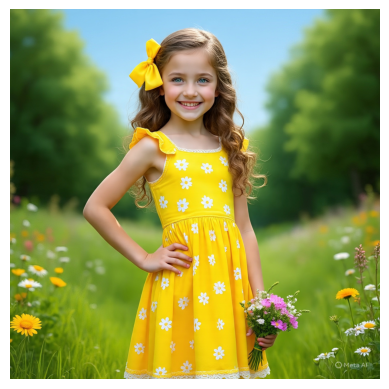

In [ ]:
img_path = input("Enter path: ")
img = plt.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
result = predict_image(image_model, img_path, device=current_device)
if result:
    print(f"\n📷 Image: {result['image_path']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']}")
    print(f"Probability (FAKE): {result['probability']}")